## Exercise 2: use of pre-trained model to classify the photoes in reality 

Use the pre-trained model on the full imagenet dataset, which contains over 10 million images and 10 thousands classes.
We use a pre-trained Resnet 50-layer model on Imagenet (http://data.mxnet.io/models/)

In [9]:
# Download 
import os, urllib
def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.urlretrieve(url, filename)
def get_model(prefix, epoch):
    download(prefix+'-symbol.json')
    download(prefix+'-%04d.params' % (epoch,))

get_model('http://data.mxnet.io/models/imagenet/resnet/50-layers/resnet-50', 0)

In [10]:
# Initilize 
import mxnet as mx
sym, arg_params, aux_params = mx.model.load_checkpoint('resnet-50', 0)

In [3]:
#Check and visualize the model 
mx.viz.plot_network(sym) 

In [ ]:
# Print the argument parameters and auxilary parameters 
arg_params 

In [ ]:
# Print the auxiliaries that contain the the mean and std for the batch normalization layers.
aux_params 

In [11]:
# Prepare and load the model 
mod = mx.mod.Module(symbol=sym, context=mx.cpu()) # changed into mx.gpu() if used for GPU 
mod.bind(for_training = False,
         data_shapes=[('data', (1,3,224,224))])
mod.set_params(arg_params, aux_params)

In [12]:
# Define the helper functions for loading the image and prediction function and get the class labels used in classification 
%matplotlib inline
import matplotlib
matplotlib.rc("savefig", dpi=100)
import matplotlib.pyplot as plt
import cv2
import numpy as np
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

def get_image(filename):
    img = cv2.imread(filename)  # read image in b,g,r order
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   # change to r,g,b order
    img = cv2.resize(img, (224, 224))  # resize to 224*224 to fit model
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)  # change to (channel, height, width)
    img = img[np.newaxis, :]  # extend to (example, channel, heigth, width)
    return img

def predict(filename, mod, synsets):
    img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
    if img is None:
        return None
    img = cv2.resize(img, (224, 224))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2) 
    img = img[np.newaxis, :] 
    
    mod.forward(Batch([mx.nd.array(img)]))
    prob = mod.get_outputs()[0].asnumpy()
    prob = np.squeeze(prob)
    a = np.argsort(prob)[::-1]    
    for i in a[0:5]:
        print('probability=%f, class=%s' %(prob[i], synsets[i]))
    

download('http://data.mxnet.io/models/imagenet/resnet/synset.txt')
with open('synset.txt') as f:
    synsets = [l.rstrip() for l in f]
#synsets    

[17461, 16120, 18926, 6176]


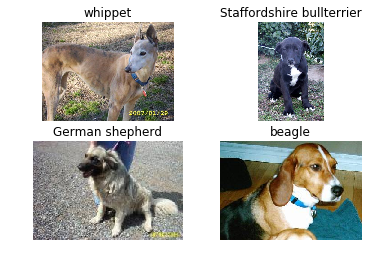

In [16]:
# Select the photoes for cat and dog saved in the data path and test the classification
#Get the random index 
import random 
import cv2 
from os import listdir
from os.path import isfile, join
bpath='/input/catdog/train'
onlyfiles = [f for f in listdir(bpath) if isfile(join(bpath, f))]
pnum=4
rindex=[random.randint(0,len(onlyfiles)) for i in range(0,pnum)]
print(rindex)

for i in range(0,pnum):
    imgpath=bpath+'/'+onlyfiles[rindex[i]]
    img = cv2.cvtColor(cv2.imread(imgpath), cv2.COLOR_BGR2RGB)
    img2 = get_image(imgpath)
    mod.forward(Batch([mx.nd.array(img2)]))
    prob = mod.get_outputs()[0].asnumpy()
    y = np.argsort(np.squeeze(prob))[::-1]
    label = synsets[y[0]]
    label = ' '.join(label.split(',')[0].split(' ')[1:])
    plt.subplot(pnum/2,2,i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(label)

probability=0.996021, class=n02510455 giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca
probability=0.000599, class=n02509815 lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens
probability=0.000462, class=n02447366 badger
probability=0.000175, class=n02445715 skunk, polecat, wood pussy
probability=0.000164, class=n02492035 capuchin, ringtail, Cebus capucinus


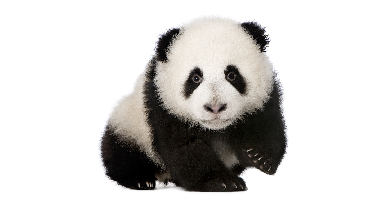

In [13]:
# Use the pretrained model to predict the class of an online photo 
def get_url2image(url, show=True):
    filename = url.split("/")[-1]
    urllib.urlretrieve(url, filename)
    img = cv2.imread(filename)
    if img is None:
        print('failed to download ' + url)
    if show:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    return filename

url = 'http://weknowyourdreams.com/images/animals/animals-04.jpg'
predict(get_url2image(url), mod, synsets)